In [111]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [112]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [113]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [114]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [115]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [116]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [117]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [118]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [119]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [120]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp = calc_temps('2017-08-01', '2017-08-07')

temp_df = pd.DataFrame(temp, columns=['tmin','tavg', 'tmax'])
temp_df

,tmin,tavg,tmax
0,72.0,79.25,83.0


Text(0, 0.5, 'Temperature (F)')

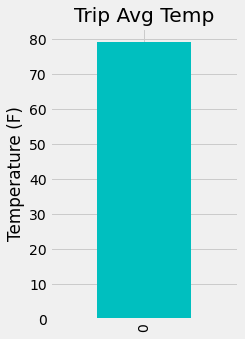

In [121]:
# Plot the results from your previous query as a bar chart. 
temp_df1 = temp_df['tavg']



## Plot Bar Chart and error Bars

temp_df1.plot(kind='bar', figsize=(3,5), color='c', alpha=1)

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

# Use the average temperature for bar height (y value)
plt.ylabel("Temperature (F)")

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

### Daily Rainfall Average

In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('total_rainfall')).\
    filter(Station.station == Measurement.station).\
        filter(Measurement.date >= '2017-08-01').\
            filter(Measurement.date <= '2017-08-07').\
                order_by(func.sum(Measurement.prcp).desc()).\
                    group_by(Station.station).all()
result
pd.DataFrame(result)


,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [123]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [218]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
result1 = session.query(Measurement.date, Measurement.tobs, func.strftime("%m-%d", Measurement.date).label('M-D')).\
    filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).order_by(Measurement.date).all()

result1

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normal = []
for result in result1:
    # print(result)
    # print(result[0])
    # print(result[0][2])
    normal.append(daily_normals(result[2]))
normal

# result2 = result
# result2

# daily_normals(result1[0])


[[(67.0, 75.54, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(67.0, 76.25, 83.0)],
 [(67.0, 76.25, 83.0)],
 [(67.0, 76.25, 83.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [215]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
pd.DataFrame(normal)

,0
0,"(67.0, 75.54, 83.0)"
1,"(67.0, 75.54, 83.0)"
2,"(67.0, 75.54, 83.0)"
3,"(67.0, 75.54, 83.0)"
4,"(68.0, 75.60377358490567, 84.0)"
5,"(68.0, 75.60377358490567, 84.0)"
6,"(68.0, 75.60377358490567, 84.0)"
7,"(68.0, 75.60377358490567, 84.0)"
8,"(70.0, 76.61111111111111, 85.0)"
9,"(70.0, 76.61111111111111, 85.0)"


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session